<h1> Section 1: Verify the file content

In [19]:
# I would like to first verify if OSM file elements match with documentation ! 
# Just to make sure file is not corrupt or contains data not explained in documentation
# http://wiki.openstreetmap.org/wiki/OSM_XML
# Verify file has only 3 instances (node, way, relation) 
# Print summary on number of elements and their attributes 

# you might see these import functions in all of the sections. 
# so I don't have to run code from 1st section when I restart my computer
import pprint
import re
import xml.etree.cElementTree as ET

osm_file = 'BuffaloNiagaraArea.osm'
counter = 1
context = ET.iterparse(osm_file, events=('start', 'end'))
_, root = next(context)

intsances = set()
elemsAttribs = {}
startElm = None
for event, elem in context:
    if event == 'start' and startElm == None:
        # store each level-1 elemnt after root and add to instances when event reaches end of that element
        startElm = elem
    if event == 'end' and startElm == elem:
        intsances.add(elem.tag)
        # Lets build dictionary of all elements and their attributes
        if elem.tag not in elemsAttribs:
            elemsAttribs[elem.tag] = {'attributes': set(list(elem.attrib.keys())), 'children': {}}
        else:
            for attrib in elem.attrib.keys():
                elemsAttribs[elem.tag]['attributes'].add(attrib)
        
        for child in elem.iter():
            if child <> elem:
                if child.tag not in elemsAttribs[elem.tag]['children']:
                    elemsAttribs[elem.tag]['children'][child.tag] = set(list(child.attrib.keys()))
                else:
                    for attrib in child.attrib.keys():
                        elemsAttribs[elem.tag]['children'][child.tag].add(attrib)
        
        startElm = None
        root.clear()
        
print 'instances: ', intsances, '\n'
print 'instances-Attributes-Children:'
pprint.pprint(elemsAttribs)

<h1> Section 2: What is "k" and "role"

In [2]:
# build dictionary for values in attributes k and role with their count

import pprint
import re
import xml.etree.cElementTree as ET

osm_file = 'BuffaloNiagaraArea.osm'
counter = 1
context = ET.iterparse(osm_file, events=('start', 'end'))
_, root = next(context)

k_role_vals = {
                'node': {'k': {}},   #K dictionary will have their values and count
                'way': {'k': {}}, 
                'relation':{'k': {}, 'role': {}}  #role dictionary will have their values and count
                }
for event, elem in context:
    if elem.tag in ['node', 'way', 'relation'] and event == 'end':
        for child in elem.iter('tag'):
            if 'k' in child.attrib:
                if child.attrib['k'] in k_role_vals[elem.tag]['k']:
                    k_role_vals[elem.tag]['k'][child.attrib['k']] += 1  #increment count for value of "k"
                else:
                    k_role_vals[elem.tag]['k'][child.attrib['k']] = 1 #append value of "k" into k dictionary
            else:
                # All <tag>'s expected to have attribute k 
                print 'No key in one of the tags ', elem.attrib

    if elem.tag == 'relation' and event == 'end':
        for child in elem.iter('member'):
            if 'role' in child.attrib:
                if child.attrib['role'] in k_role_vals[elem.tag]['role']:
                    k_role_vals[elem.tag]['role'][child.attrib['role']] += 1 
                else:
                    k_role_vals[elem.tag]['role'][child.attrib['role']] = 1
    
    if event == 'end':
        root.clear()
        
pprint.pprint(k_role_vals)

<h1> Section 3

In [3]:
# print distinct values of Country, City, postcode, state, province with their count

import pprint
import re
import xml.etree.cElementTree as ET

osm_file = 'BuffaloNiagaraArea.osm'
node_addr_vals = {
                'addr:country': {},   
                'addr:postcode': {}, 
                'addr:city': {},  
                'addr:state': {},
                'addr:province': {}
                }

context = ET.iterparse(osm_file, events=('start', 'end'))
_, root = next(context)
for event, elem in context:
    if elem.tag == 'node' and event == 'end':
        for child in elem.iter('tag'):
            if child.attrib['k'] in ['addr:country', 'addr:city', 'addr:postcode', 'addr:state', 'addr:province']:
                # Lets add attribute 'v' value as key and count as values into dictionary
                if child.attrib['v'] in node_addr_vals[child.attrib['k']]:
                    node_addr_vals[child.attrib['k']][child.attrib['v']] += 1 
                else:
                    node_addr_vals[child.attrib['k']][child.attrib['v']] = 1
    if event == 'end':
        root.clear()
        
pprint.pprint(node_addr_vals)

<h1> Section 4

In [4]:
# check if tag has any other attribute in case node has city Niagara Falls but not having Country, State, postcode

import pprint
import re
import xml.etree.cElementTree as ET

osm_file = 'BuffaloNiagaraArea.osm'
counter = 1
context = ET.iterparse(osm_file, events=('start', 'end'))
_, root = next(context)

addr_keys = {}  # count of each k attribute in address nodes
count_niagara_addrs = 0

for event, elem in context:
    if elem.tag == 'node' and event == 'end':
        tag_data = {}  # store all keys and values of tags.
        for child in elem.iter('tag'):
            tag_data[child.attrib['k']] = child.attrib['v']
            if child.attrib['k'] in ['addr:country','addr:province','addr:state','addr:postcode']:
                break   #if node has country/state/postcode, skip that node, we can use one of them to filter Canada
        
        if 'addr:city' in tag_data and tag_data['addr:city'] in ['City of Niagara Falls', 'Niagara Falls']:
            if 'addr:country' not in tag_data and 'addr:province' not in tag_data and \
               'addr:state' not in tag_data and 'addr:postcode' not in tag_data:
                    count_niagara_addrs += 1
                    for key in tag_data:
                        if key in addr_keys:
                            addr_keys[key] += 1
                        else:
                            addr_keys[key] = 1
    if event == 'end':
        root.clear()

print 'Total addresses in Niagara Falls with no country filter data: ', count_niagara_addrs
pprint.pprint(addr_keys)

<h1> Section 5

In [76]:
# Lets find out distinct values of Source in address nodes
# The code has logic similar to above section in finding nodes to build source values
import pprint
import re
import xml.etree.cElementTree as ET

osm_file = 'BuffaloNiagaraArea.osm'
counter = 1
context = ET.iterparse(osm_file, events=('start', 'end'))
_, root = next(context)

source_values = {}  # count of each k attribute in address nodes

for event, elem in context:
    if elem.tag == 'node' and event == 'end':
        
        tag_data = {}  # store all keys and values of tags.
        for child in elem.iter('tag'):
            tag_data[child.attrib['k']] = child.attrib['v']
            if child.attrib['k'] in ['addr:country','addr:province','addr:state','addr:postcode']:
                break   #if node has country/state/postcode, skip that node, we can use one of them to filter Canada
        
        if 'addr:city' in tag_data and tag_data['addr:city'] in ['City of Niagara Falls', 'Niagara Falls']:
            if 'addr:country' not in tag_data and 'addr:province' not in tag_data and \
               'addr:state' not in tag_data and 'addr:postcode' not in tag_data and \
                'source' in tag_data:
                    if tag_data['source'] in source_values:
                        source_values[tag_data['source']] += 1
                    else:
                        source_values[tag_data['source']] = 1
                    
    if event == 'end':
        root.clear()

pprint.pprint(source_values)

{'CanVec 6.0 - NRCan': 775, 'NRCan-CanVec-10.0': 12658}


<h1> Section 6: Lets look at 'gnis:' data (Geographic Names Information System)

In [5]:
# Retrieve all keys of gnis nodes and their count

import pprint
import re
import xml.etree.cElementTree as ET

osm_file = 'BuffaloNiagaraArea.osm'
context = ET.iterparse(osm_file, events=('start', 'end'))
_, root = next(context)

gnis_keys = {}  # count of each k attribute in gnis nodes
count_gnis = 0

for event, elem in context:
    if elem.tag == 'node' and event == 'end':
        tag_data = []  # store all keys of tags.
        gnis = 'N'
        for child in elem.iter('tag'):
            tag_data.append(child.attrib['k'])
            if child.attrib['k'][0:5] == 'gnis:':
                gnis = 'Y'  #Its a gnis node
                
        if gnis == 'Y':
            count_gnis += 1
            for key in tag_data:
                if key in gnis_keys:
                    gnis_keys[key] += 1
                else:
                    gnis_keys[key] = 1
         
    if event == 'end':
        root.clear()

print 'Total gnis nodes: ', count_gnis
pprint.pprint(gnis_keys)

<h1> Section 7: distinct street names 

In [7]:
# print distinct values of addr:street with their count
# we know uaually last word of street defines type of street (County, drive, street etc), so 
# lets print all last words and see if any unfamiliar (but might be correct) words.
import pprint
import re
import xml.etree.cElementTree as ET

osm_file = 'BuffaloNiagaraArea.osm'

#Street names for each country, Unknown dictionary where country is not determined
addr_streets = {'US': {}, 'CA': {}, 'Unknown': {}}
street_types = {'US': {}, 'CA': {}, 'Unknown': {}}
total_addr = {'US': 0, 'CA': 0, 'Unknown': 0}

noCounrty_nodes_keys = {}  

#Please come back to round-2 code after you read analysis of this section result 
source_values = {}

context = ET.iterparse(osm_file, events=('start', 'end'))
_, root = next(context)
for event, elem in context:
    if elem.tag == 'node' and event == 'end':
        tag_data = {}
        street = 'N'
        for child in elem.iter('tag'):
            tag_data[child.attrib['k']] = child.attrib['v']
            if child.attrib['k'] == 'addr:street':
                street = 'Y'  #The node has street
                
        if street == 'N':
            continue  #go to next node if it's not addr node
        
        country = 'Unknown'
        if 'addr:country' in tag_data:
            country = tag_data['addr:country'] 
            
            # postcodes and city names will be cleaned later, but here we just compare as it is in OSM       
        elif 'addr:postcode' in tag_data:
            if tag_data['addr:postcode'][0:2] == '14':
                country = 'US'
            elif len(tag_data['addr:postcode']) > 5:
                country = 'CA'

        elif 'addr:province' in tag_data:
            country = 'CA'

        elif 'addr:state' in tag_data:
            if tag_data['addr:state'] in ['ON', 'Ontario']:
                country = 'CA'
            else:
                country = 'US' 
        
        elif 'addr:city' in tag_data:
            if tag_data['addr:city'] in ['City of Niagara Falls', 'City of Port Colborne', \
                                         'Niagara Falls', 'Niagara Falls, ON', 'Town of Fort Erie', \
                                         'Town of Niagara-On-The-Lake']:
                country = 'CA'
            elif tag_data['addr:city'] == '': # we have one city with no Value, if country for that node hasn't been
                None                         # determined above, it goes as Unknown.
            else:
                country = 'US'
        # Round-3
        #elif 'source' in tag_data and tag_data['source'] == 'StatCan 92-500-X':
        #    country = 'CA'
                   
        # update street names and count
        if tag_data['addr:street'] in addr_streets[country]:
            addr_streets[country][tag_data['addr:street']] += 1 
        else:
            addr_streets[country][tag_data['addr:street']] = 1
            
        # update street types and count
        st_stype = tag_data['addr:street'].split(' ')[-1]  # get last word from street name
        if st_stype in street_types[country]:
            street_types[country][st_stype] += 1 
        else:
            street_types[country][st_stype] = 1
        
        #Capture all key attributes of nodes incase country is Unknown
        # we will see if any other elemenet can be used to derive country
        if country == 'Unknown':
            for key in tag_data: 
                if key in noCounrty_nodes_keys:
                    noCounrty_nodes_keys[key] += 1 
                else:
                    noCounrty_nodes_keys[key] = 1
        # Round-2 starts   
            if 'source' in tag_data:
                if tag_data['source'] in source_values:
                    source_values[tag_data['source']] += 1 
                else:
                    source_values[tag_data['source']] = 1
        # Round-2 Ends
    
        total_addr[country] += 1 
                
    if event == 'end':
        root.clear()
        
print 'Address Counts in each country: ', total_addr
print 'Total streets in US: ', len(addr_streets['US']), '\n', 'Total streets in CA: ', len(addr_streets['CA']), '\n', \
        'Total streets in Unknown: ', len(addr_streets['Unknown'])
print 'Streets: '
pprint.pprint(addr_streets)
print 'Street Types: '
pprint.pprint(street_types)
print 'Unknown country node attributes: '
pprint.pprint(noCounrty_nodes_keys)
# Round 2
print 'Source values: '
pprint.pprint(source_values) 

<h1> Section 8: Create Json file with cleanup method discussed above </h1>
 (Json schema is same as we used in our MongoDB lesson case study)

In [50]:
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json

problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
street_types = {'Ln':'Lane', 'Niagara': '', 'Rd':'Road', 'Blvd':'Boulevard', 
              'Dr': 'Drive', 'St':'Street', 'St.':'Street', 'ave':'Avenue'}
city_map = {'City of': '', 'Town of': ''}
state_codes = {'ONTARIO': 'ON', 'NEW YORK': 'NY'}
us_zip = re.compile(r'^\d{5}(?:[-\s]\d{4})?$')
ca_zip = re.compile(r'^[A-Za-z]\d[A-Za-z][ -]?\d[A-Za-z]\d$')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

def shape_element(element):
    if element.tag in ["node", "way"]:
        if element.tag == 'node':
            node = {'type': 'node'}
            node['pos'] = [float(element.attrib['lat']), float(element.attrib['lon'])] 
        else:
            node = {'type': 'way'}
            
        node['id'] = element.attrib['id']
        node['created'] = {}
        for attr in CREATED:
            node['created'][attr] = element.attrib[attr]
            
        for tag in element.iter('tag'):
            if tag.attrib['k'][0:11] == 'addr:street:':
                continue
            if re.match(problemchars, tag.attrib['k']):
                continue
            if tag.attrib['k'][0:5] == 'addr:':
                '''
                if 'address' not in node:
                    node['address'] = {}
                
                #program failed at following line for one node, I set in debug in eclipse, node '543619696' has tag 
                # <tag k="address" v="22 Westminster Street, Buffalo, NY 14215"/>
                # this causes node dictionary to have key 'address' with type string, following tag has 'addr:city'
                # and it reaches this line to add dict 'city':'Buffalo' inside address and it fails.
                
                node['address'][tag.attrib['k'].split(':',1)[1]] =  tag.attrib['v'] 
                '''
                # the above if code has been changed after analysing address attributes in next code cell
                if 'address' not in node:
                    node['address'] = {}
                if type(node['address']) == type('string'):
                    continue   #if we have address tag, we will ignore addr: tags.
                node['address'][tag.attrib['k'].split(':',1)[1]] =  tag.attrib['v']
                continue
            if tag.attrib['k'][0:5] == 'gnis:':
                if 'gnis' not in node:
                    node['gnis'] = {}
                node['gnis'][tag.attrib['k'].split(':',1)[1]] =  tag.attrib['v']
                continue
            #Section 2 shows all K attrbutes of Tags,seacmark has lot of attributes, so lets seperate it.
            #It would be useful to find semark nodes later using mongoDB query.
            if tag.attrib['k'][0:8] == 'seamark:':  
                if 'seamark' not in node:
                    node['seamark'] = {}
                node['seamark'][tag.attrib['k'].split(':',1)[1]] =  tag.attrib['v']
                continue
                
            node[tag.attrib['k']] = tag.attrib['v']
            
        for count, nd in enumerate(element.iter('nd')):
            if count == 0:
                node['node_refs'] = []
            node['node_refs'].append(nd.attrib['ref'])
        
        # this code is added to fix problem we have seen in 'addr:' code above.
        # this parses one lines address into multiple fields
        if 'address' in node and type(node['address']) == type('string'):
            addr = node['address'].split(',') 
            #addr = ['Number Street Name', 'Line 2 (ex: PO box)', 'City', 'State postcode']
            node['address'] = {'housenumber': addr[0].strip().split(' ')[0], 
                               'street': addr[0].strip().split(' ', 1)[1],
                               'city': addr[-2].strip(),
                               'state':addr[-1].strip().split(' ')[0],
                               'postcode':addr[-1].strip().split(' ')[1],
                               'country': 'US'}
            
        # Address cleanup as explained in previous section
        if 'address' in node:
            if 'street' in node['address']:
                for code, desc in street_types.iteritems():
                    node['address']['street'] = node['address']['street'].replace(code, desc)
                node['address']['street'].capitalize()
                
            if 'city' in node['address']:
                node['address']['city'] = node['address']['city'].split(',')[0] #strip state name
                node['address']['city'] = node['address']['city'].split('.')[0] #strip state name
                for code, desc in city_map.iteritems():
                    node['address']['city'] = node['address']['city'].replace(code, desc)
                node['address']['city'].capitalize()
                if node['address']['city'] == '':
                    del node['address']['city']
                
            if 'postcode' in node['address']:
                if not re.match(us_zip, node['address']['postcode']) and \
                not re.match(ca_zip, node['address']['postcode']):
                    del node['address']['postcode']
                                    
            if 'province' in node['address']:
                node['address']['state'] = node['address']['province']
                del node['address']['province']
            if 'state' in node['address']:
                node['address']['state'].upper()
                for desc, code in state_codes.iteritems():
                    node['address']['state'] = node['address']['state'].replace(desc, code)
            
            # Derrive country code
            if 'country' not in node['address']:
                if 'source' in node and node['source'] == 'StatCan 92-500-X':
                    node['address']['country'] = 'CA'
                elif 'postcode' in node['address']:
                    if re.match(us_zip, node['address']['postcode']):
                        node['address']['country'] = 'US'
                    else:
                        node['address']['country'] = 'CA'
                elif 'state' in node['address']:
                    if node['address']['state'] == 'NY':
                        node['address']['country'] = 'US'
                    else:
                        node['address']['country'] = 'CA'
                elif 'city' in node['address']:
                    if node['address']['city'] in ['Niagara falls', 'Port colborne', \
                                         'Fort erie', 'Niagara-on-the-lake']:
                        node['address']['country'] = 'CA'
                    else:
                        node['address']['country'] = 'US'
                else:
                    node['address']['country'] = 'Unknown'
                            
        return node
    else:
        return None


def process_map(file_in, pretty = False):
    # You do not need to change this file
    file_out = "{0}.json".format(file_in)
    
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return data

if __name__ == "__main__":
    process_map('BuffaloNiagaraArea.osm', False)

Alright, Json file is created successfully. I have manually verified some data, it's as expected. Ofcourse, my OSM and Json files are just 100 MB, So I am able to open using windows application, if file size is very large, I can't open with simple applications, so I will have to verify programatically.

In [9]:
# This code is to analyse address nodes based on 'addr:' problem in above code cell
# Section 2 shows we have 30 nodes with 'address' as key. Lets print all of them and see

import pprint
import re
import xml.etree.cElementTree as ET

osm_file = 'BuffaloNiagaraArea.osm'
counter = 1
context = ET.iterparse(osm_file, events=('start', 'end'))
_, root = next(context)

node_tags = {}  

for event, elem in context:
    if elem.tag == 'node' and event == 'end':
        
        tag_data = {}  # store all keys and values of tags.
        for child in elem.iter('tag'):
            tag_data[child.attrib['k']] = child.attrib['v']
            
        if 'address' in tag_data:
            print tag_data['address']
            node_tags[elem.attrib['id']] = tag_data
                    
    if event == 'end':
        root.clear()

pprint.pprint(node_tags)

##### Section 9

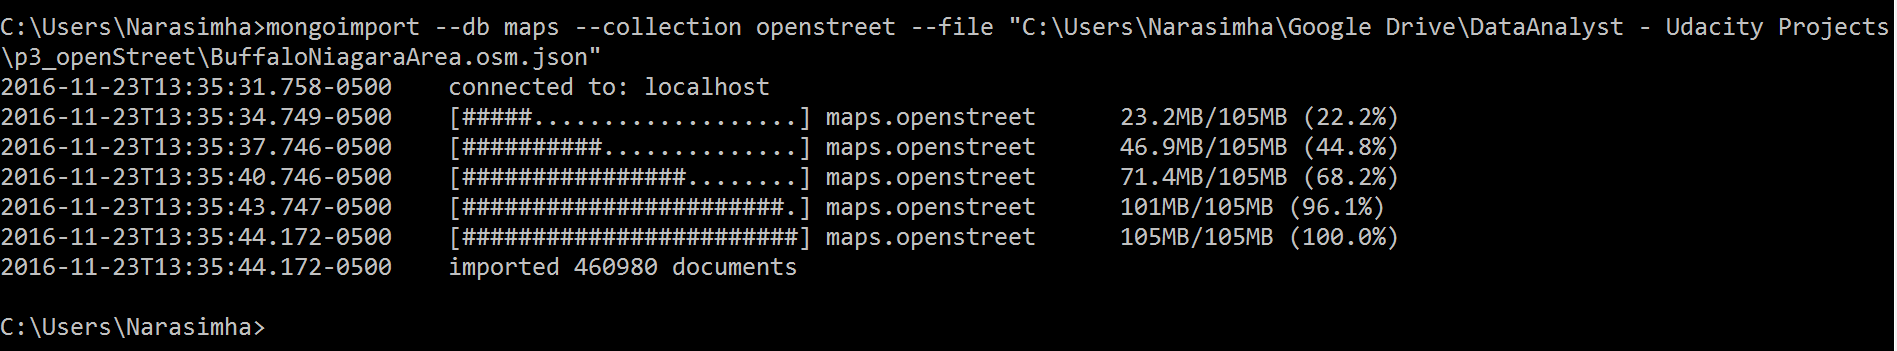

In [48]:
#JSON file has been successfully imported into mongoDB
from IPython.display import Image
Image(filename='mongoimport.PNG')

In [61]:
# Lets try finding some data in collection openstreet to verify import
# Please refere back to section 3 result, it shows zip code 14227 with count 1. Lets try query that.
# infact this is my town, I would like to know whats in this node.
from pymongo import MongoClient
import pprint

client = MongoClient('localhost:27017')
db = client.maps
cursor = db.openstreet.find({'address.postcode': '14227'})

for document in cursor:
    pprint.pprint(document)

{u'_id': ObjectId('5835e175b24e0d5c61162953'),
 u'address': {u'city': u'Cheektowaga',
              u'country': u'US',
              u'housenumber': u'1030',
              u'postcode': u'14227',
              u'state': u'NY',
              u'street': u'Losson Road'},
 u'amenity': u'library',
 u'created': {u'changeset': u'8466784',
              u'timestamp': u'2011-06-17T17:37:13Z',
              u'uid': u'70696',
              u'user': u'xybot',
              u'version': u'3'},
 u'id': u'543619612',
 u'name': u'Cheektowaga Public Library (Julia Boyer Reinstein Library)',
 u'pos': [42.8805949, -78.7191706],
 u'type': u'node'}
{u'_id': ObjectId('5835e175b24e0d5c61162955'),
 u'address': {u'city': u'Cheektowaga',
              u'country': u'US',
              u'housenumber': u'2660',
              u'postcode': u'14227',
              u'state': u'NY',
              u'street': u'William Streetreet'},
 u'amenity': u'library',
 u'created': {u'changeset': u'11100494',
              u'timestamp

hmmm...we expected one, but got 3 of them. Yes, Section 3 result was only from 'addr:postcode', but we have also parsed 'address' attribute of <tag> in our previous section to create json file. That has 2 more.

Not important, :-) my current location is printed above. I am right now sitting in 'Cheektowaga Public Library' (1st node above). I have done most of this project in this quiet library.

Alright initial verification is successful, lets try getting some more options out of this data based on Tag attributes we have listed in section 2 result.

(JSON file is not huge, so I would go ahead to run queries with no indexes, if we see requirement of it anytime, we will create)

In [12]:
# I see 'amenity' in > 2000 nodes and ways. Lets try to see what we got 
from pymongo import MongoClient
import pprint

client = MongoClient('localhost:27017')
db = client.maps

pipeline = [{"$group": {"_id": {"type":"$type", "amenity":"$amenity"}, 
                        "count":{"$sum":1}}}, 
            {"$sort":{"_id.type":1,"count":-1}}] 
           
amenities = db.openstreet.aggregate(pipeline)
for amenity in amenities:
    pprint.pprint(amenity)



Oops, seems something incorrect! we have additional types (not just Node and way). If I look at section 2 result, seems way has tag's with attribute 'type', JSON file creation has overriden program creation type node/way.

I have verified other fields created in our program, we don't have conflict for others. We have 2 options to correct this.
1. GO back to Section 8, add code to rename 'type' attribute of tag and rerun all steps from there.
2. We know only way has 'type' in tags, so we can directly update documents in mongoDB where type is not way or node. We should rename current 'type' and add 'type':'way'

for me 2nd option is easier.

In [80]:
# verify count of type not in 'node' 'way', it should be 83 as Section 2 shows 83 'type' tags in ways.
from pymongo import MongoClient
import pprint

client = MongoClient('localhost:27017')
db = client.maps
cursor = db.openstreet.find({'type': {'$nin':['node', 'way']}})

print db.openstreet.count({'type': {'$nin':['node', 'way']}})
print cursor[0]
 

83
{u'node_refs': [u'256531100', u'111635740', u'3350678925', u'4231385094'], u'name': u'Riverwalk', u'tiger:cfcc': u'A71', u'created': {u'changeset': u'39877549', u'version': u'33', u'uid': u'36737', u'timestamp': u'2016-06-08T06:38:09Z', u'user': u'gadget'}, u'route': u'bicycle', u'tiger:reviewed': u'no', u'state': u'proposed', u'tiger:county': u'Erie, NY', u'foot': u'yes', u'_id': ObjectId('5835e17db24e0d5c611af6b6'), u'type': u'route', u'id': u'12274796', u'highway': u'cycleway', u'segregated': u'no'}


In [81]:
#Ok, above count is good, lets update these 83 documents.
from pymongo import MongoClient
import pprint

client = MongoClient('localhost:27017')
db = client.maps
cursor = db.openstreet.find({'type': {'$nin':['node', 'way']}})

for document in cursor:
    document['wayType'] = document['type']
    document['type'] = 'way'
    db.openstreet.update({'id':document['id']}, document) 

C:\Users\Narasimha\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: update is deprecated. Use replace_one, update_one or update_many instead.


In [14]:
# Lets analyse amenity now

from pymongo import MongoClient
import pprint

client = MongoClient('localhost:27017')
db = client.maps
#This should match total count in section 2 (2174 + 2339 = 4513)
total_amenities = db.openstreet.count({"amenity":{"$exists": True}})
print 'Total nodes/way with Amenity: ', total_amenities
assert total_amenities == 4513

pipeline = [{'$match': {"amenity":{"$exists": True}}}, 
        {"$group": {"_id": {"type":"$type", "amenity":"$amenity"}, "count":{"$sum":1}}}, 
        {"$sort":{"type":1, "count":-1}}] 
           
amenities = db.openstreet.aggregate(pipeline)
for amenity in amenities:
    pprint.pprint(amenity)

In [12]:
# we better have index on streetmap collection
from pymongo import IndexModel, ASCENDING, DESCENDING
index1 = IndexModel([("id", ASCENDING)])
index2 = IndexModel([("amenity", ASCENDING)])
db.openstreet.create_indexes([index1, index2])

[u'id_1', u'amenity_1']

In [15]:
#Check if amenity node/way has address
from pymongo import MongoClient
import pprint

client = MongoClient('localhost:27017')
db = client.maps
# amenities = {parking: {total: 10, addrExist: 6}, ...}
amenities = {}

#Lets get total count of amenties
pipeline = [{'$match': {"amenity":{"$exists": True}}}, 
        {"$group": {"_id": {"amenity":"$amenity"}, "count":{"$sum":1}}}] 
cursor = db.openstreet.aggregate(pipeline)
for document in cursor:
    amenities[document['_id']['amenity']] = {'total': document['count'], 'addrExist': 0}

#Node/way will have address element to count
pipeline = [{'$match': {"amenity":{"$exists": True}, "address":{"$exists": True}}}, 
        {"$group": {"_id": {"amenity":"$amenity"}, "addrCount":{"$sum":1}}}] 
cursor = db.openstreet.aggregate(pipeline)
for document in cursor:
    amenities[document['_id']['amenity']]['addrExist'] = document['addrCount'] 


#if way doesn't have address element, any of the related nodes might have
cursor = db.openstreet.find({"type":"way", "amenity":{"$exists": True}, "address":{"$exists": False}, 
                             "node_refs":{"$exists": True}})
for document in cursor:
    #query to check nodes with address
    if db.openstreet.count({"type":"node", 'id': {'$in':document['node_refs']}, "address":{"$exists": True}}) > 0:
        amenities[document['_id']['amenity']]['addrExist'] += 1

pprint.pprint(amenities)
        

In [77]:
#Statistical overview of dataset
from pymongo import MongoClient
import pprint

client = MongoClient('localhost:27017')
db = client.maps
stats = db.command("collstats", "openstreet")
print 'Size: ', stats['size']/1e6, 'MB, Count: ', stats['count']
print 'Number of Users: ', len(db.openstreet.distinct("created.uid"))
print 'Number of Nodes, Ways: ',  db.openstreet.count({"type":"node"}), db.openstreet.count({"type":"way"}) 
print 'Number of users for nodes, Ways: ', len(db.openstreet.distinct("created.uid",{"type":"node"})), \
                                           len(db.openstreet.distinct("created.uid",{"type":"way"}))
print 'Total Amenities, GNIS Amenities :',db.openstreet.count({"amenity":{"$exists": True}}), \
                                          db.openstreet.count({"amenity":{"$exists": True}, "gnis":{"$exists": True}})

Size:  117.317318 MB, Count:  460980
Number of Users:  632
Number of Nodes, Ways:  395758 65222
Number of users for nodes, Ways:  554 460
Total Amenities, GNIS Amenities : 4513 536
